In [1]:
import pandas as pd

In [2]:
df =pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


In [4]:
import pandas as pd
print(df['fuel_efficiency_mpg'].describe())

count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64


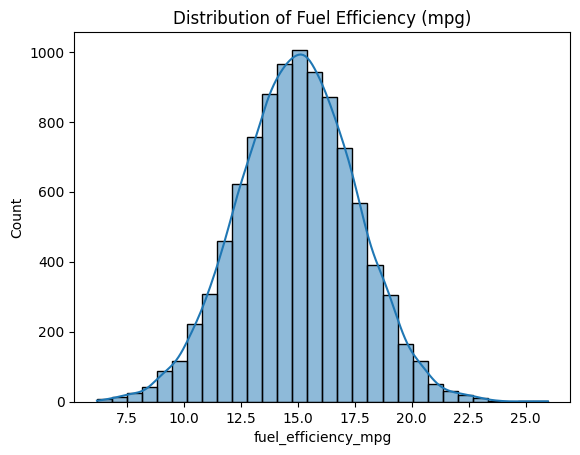

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df['fuel_efficiency_mpg'], kde=True, bins=30)
plt.title('Distribution of Fuel Efficiency (mpg)')
plt.xlabel('fuel_efficiency_mpg')
plt.ylabel('Count')
plt.show()

In [6]:
skewness = df['fuel_efficiency_mpg'].skew()
print("Skewness:", skewness)


Skewness: -0.012062219273507922


In [7]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [8]:
median_hp = df['horsepower'].median()
print(median_hp)


149.0


In [12]:
import numpy as np
np.random.seed(42)
df_filtered = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [13]:
n = len(df_filtered)
n_train = int(n * 0.6)
n_val   = int(n * 0.2)
n_test  = n - n_train - n_val  # remainder

train = df_filtered.iloc[:n_train].copy()
val   = df_filtered.iloc[n_train:n_train+n_val].copy()
test  = df_filtered.iloc[n_train+n_val:].copy()

print(len(train), len(val), len(test))  # sanity check


5822 1940 1942


In [14]:
import numpy as np

class LinearRegression:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        if not np.all(X[:,0] == 1):
            X = np.hstack([np.ones((X.shape[0], 1)), X])
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        if not np.all(X[:,0] == 1):
            X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X @ self.w


In [15]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

X_train = train[features].to_numpy()
y_train = train[target].to_numpy()
X_val = val[features].to_numpy()
y_val = val[target].to_numpy()

X_train_0 = np.where(np.isnan(X_train), 0, X_train)
X_val_0 = np.where(np.isnan(X_val), 0, X_val)

model_0 = LinearRegression()
model_0.fit(X_train_0, y_train)
y_pred_0 = model_0.predict(X_val_0)
rmse_0 = round(np.sqrt(np.mean((y_val - y_pred_0) ** 2)), 2)
rmse_0


np.float64(0.52)

In [16]:
mean_hp = np.nanmean(X_train[:, 1])
X_train_mean = X_train.copy()
X_val_mean = X_val.copy()
X_train_mean[:, 1] = np.where(np.isnan(X_train_mean[:, 1]), mean_hp, X_train_mean[:, 1])
X_val_mean[:, 1] = np.where(np.isnan(X_val_mean[:, 1]), mean_hp, X_val_mean[:, 1])

model_mean = LinearRegression()
model_mean.fit(X_train_mean, y_train)
y_pred_mean = model_mean.predict(X_val_mean)
rmse_mean = round(np.sqrt(np.mean((y_val - y_pred_mean) ** 2)), 2)
rmse_mean


np.float64(0.47)

In [17]:
import numpy as np

class RidgeRegression:
    def __init__(self, r):
        self.r = r
        self.w = None

    def fit(self, X, y):
        if not np.all(X[:,0] == 1):
            X = np.hstack([np.ones((X.shape[0], 1)), X])
        n_features = X.shape[1]
        self.w = np.linalg.inv(X.T @ X + self.r * np.eye(n_features)) @ X.T @ y

    def predict(self, X):
        if not np.all(X[:,0] == 1):
            X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X @ self.w


In [18]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

X_train = train[features].to_numpy()
y_train = train[target].to_numpy()
X_val = val[features].to_numpy()
y_val = val[target].to_numpy()

X_train = np.where(np.isnan(X_train), 0, X_train)
X_val = np.where(np.isnan(X_val), 0, X_val)

r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = {}

for r in r_list:
    model = RidgeRegression(r)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse_scores[r] = round(np.sqrt(np.mean((y_val - y_pred) ** 2)), 2)

rmse_scores


{0: np.float64(0.52),
 0.01: np.float64(0.52),
 0.1: np.float64(0.53),
 1: np.float64(0.53),
 5: np.float64(0.53),
 10: np.float64(0.53),
 100: np.float64(0.53)}

In [19]:
import numpy as np

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

seeds = list(range(10))
rmse_scores = []

for seed in seeds:
    np.random.seed(seed)
    df_shuffled = df_filtered.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    n = len(df_shuffled)
    n_train = int(n * 0.6)
    n_val   = int(n * 0.2)
    n_test  = n - n_train - n_val
    
    train = df_shuffled.iloc[:n_train]
    val   = df_shuffled.iloc[n_train:n_train+n_val]
    
    X_train = np.where(np.isnan(train[features].to_numpy()), 0, train[features].to_numpy())
    y_train = train[target].to_numpy()
    
    X_val = np.where(np.isnan(val[features].to_numpy()), 0, val[features].to_numpy())
    y_val = val[target].to_numpy()
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = np.sqrt(np.mean((y_val - y_pred)**2))
    rmse_scores.append(rmse)

std_rmse = round(np.std(rmse_scores), 3)
std_rmse


np.float64(0.006)

In [20]:
np.random.seed(9)
df_shuffled = df_filtered.sample(frac=1, random_state=9).reset_index(drop=True)

n = len(df_shuffled)
n_train = int(n * 0.6)
n_val   = int(n * 0.2)
n_test  = n - n_train - n_val

train = df_shuffled.iloc[:n_train]
val   = df_shuffled.iloc[n_train:n_train+n_val]
test  = df_shuffled.iloc[n_train+n_val:]

train_val = pd.concat([train, val])

X_train_val = np.where(np.isnan(train_val[features].to_numpy()), 0, train_val[features].to_numpy())
y_train_val = train_val[target].to_numpy()

X_test = np.where(np.isnan(test[features].to_numpy()), 0, test[features].to_numpy())
y_test = test[target].to_numpy()

model = RidgeRegression(r=0.001)
model.fit(X_train_val, y_train_val)
y_pred_test = model.predict(X_test)

rmse_test = round(np.sqrt(np.mean((y_test - y_pred_test)**2)), 3)
rmse_test


np.float64(0.522)